# Results

**Inputs:**
- results/perf_metrics.csv

**Outputs:**
- results/tables/
- results/figures/

## Setup and imports

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
else:
  PROJECT_ROOT = '../'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

## Function library

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from scipy.stats import sem, t

def get_perf_metrics(y_true, y_pred, y_pred_proba):
  '''
    Calculates the performance metrics for a given set of predictions.

    Inputs
      y_true: true labels
      y_pred: predicted labels
      y_pred_proba: predicted probabilities

    Outputs
      accuracy: accuracy score
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
      FNR: False Negative Rate
      FPR: False Positive Rate
      tn: True Negatives
      fp: False Positives
      fn: False Negatives
      tp: True Positives
  '''
  accuracy = accuracy_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred_proba)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  FNR = fn / (fn + tp)
  FPR = fp / (fp + tn)

  return [accuracy, roc_auc, FNR, FPR, tn, fp, fn, tp]

def get_95_ci(data):
  '''
    Calculates the 95% confidence interval for a given set of data.

    Inputs
      data: data as a Pandas Series

    Outputs
      interval: Array of the lower and upper bounds of the confidence interval
  '''
  n = len(data)
  mean = data.mean()
  std_err = sem(data)
  interval = t.interval(0.95, n - 1, loc=mean, scale=std_err)
  return interval

In [4]:
N_RUNS = 50
perf_metrics = pd.read_csv(f'{PROJECT_ROOT}/results/perf_metrics_hybrid_{N_RUNS}_runs_2026-02-11_1523.csv')

## Performance and group fairness

In [5]:
# BASELINE PERFORMANCE
accuracy_ci = get_95_ci(perf_metrics['accuracy'])
roc_auc_ci = get_95_ci(perf_metrics['roc_auc'])
fnr_ci = get_95_ci(perf_metrics['FNR'])
fpr_ci = get_95_ci(perf_metrics['FPR'])

# FAIR PERFORMANCE
fair_accuracy_ci = get_95_ci(perf_metrics['fair_accuracy'])
fair_roc_auc_ci = get_95_ci(perf_metrics['fair_roc_auc'])
fair_fnr_ci = get_95_ci(perf_metrics['fair_FNR'])
fair_fpr_ci = get_95_ci(perf_metrics['fair_FPR'])

perf_summary = pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Accuracy': [perf_metrics['accuracy'].mean(),
                 perf_metrics['fair_accuracy'].mean()],
    'Acc. 95% CI': [f'{round(accuracy_ci[0], 3)}-{round(accuracy_ci[1], 3)}',
                    f'{round(fair_accuracy_ci[0], 3)}-{round(fair_accuracy_ci[1], 3)}'],
    'ROC AUC': [perf_metrics['roc_auc'].mean(),
                perf_metrics['fair_roc_auc'].mean()],
    'ROC AUC 95% CI': [f'{round(roc_auc_ci[0], 3)}-{round(roc_auc_ci[1], 3)}',
                       f'{round(fair_roc_auc_ci[0], 3)}-{round(fair_roc_auc_ci[1], 3)}'],
    'FNR': [perf_metrics['FNR'].mean(),
            perf_metrics['fair_FNR'].mean()],
    'FNR 95% CI': [f'{round(fnr_ci[0], 3)}-{round(fnr_ci[1], 3)}',
                  f'{round(fair_fnr_ci[0], 3)}-{round(fair_fnr_ci[1], 3)}'],
    'FPR': [perf_metrics['FPR'].mean(),
            perf_metrics['fair_FPR'].mean()],
    'FPR 95% CI': [f'{round(fpr_ci[0], 3)}-{round(fpr_ci[1], 3)}',
                  f'{round(fair_fpr_ci[0], 3)}-{round(fair_fpr_ci[1], 3)}']
})

print(perf_summary.to_markdown(index=False, numalign="right"))

| Model    |   Accuracy | Acc. 95% CI   |   ROC AUC | ROC AUC 95% CI   |      FNR | FNR 95% CI   |      FPR | FPR 95% CI   |
|:---------|-----------:|:--------------|----------:|:-----------------|---------:|:-------------|---------:|:-------------|
| Baseline |   0.860357 | 0.855-0.866   |  0.927289 | 0.923-0.931      | 0.137383 | 0.129-0.146  | 0.141709 | 0.133-0.151  |
| Fair     |   0.840415 | 0.835-0.846   |  0.904034 | 0.899-0.909      | 0.144972 | 0.137-0.153  | 0.172949 | 0.164-0.182  |


In [6]:
# Statistical significance of the difference in FNR disparity
fnr_fair_ttest = ttest_rel(perf_metrics['fair_FNR_diff'],
                           perf_metrics['FNR_diff'],
                           alternative='two-sided')
print("FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS")
print(f"Average FNR Disparity in the baseline model:\
 {perf_metrics['FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the baseline model:\
 {perf_metrics['FNR_diff'].std()*100:.2f}%")
print('-'*20)
print(f"Average FNR Disparity in the fair model:\
 {perf_metrics['fair_FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the fair model:\
 {perf_metrics['fair_FNR_diff'].std()*100:.2f}%")
print(f"Paired T-Statistic (t): {fnr_fair_ttest.statistic:.4f}")
print(f"P-value: {fnr_fair_ttest.pvalue:.6f}")
print('-'*20)


FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS
Average FNR Disparity in the baseline model: -10.23%
Std Dev FNR Disparity in the baseline model: 13.42%
--------------------
Average FNR Disparity in the fair model: 1.84%
Std Dev FNR Disparity in the fair model: 9.07%
Paired T-Statistic (t): 9.1564
P-value: 0.000000
--------------------


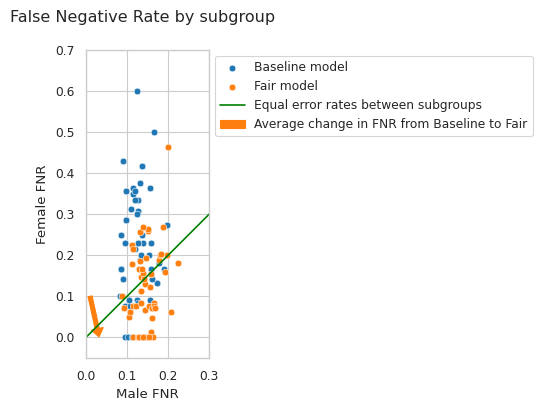

In [7]:
# Visualising difference in FNR disparity between baseline and fair model
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(perf_metrics, x='FNR_m', y='FNR_f', ax=ax, c='#1f77b4')
sns.scatterplot(perf_metrics, x='fair_FNR_m', y='fair_FNR_f', ax=ax, c='#ff7f0e')
plt.plot([0,.7],[0,.7],c='g')

fair_vx = (perf_metrics['fair_FNR_m'] - perf_metrics['FNR_m']).sum(axis=0) / perf_metrics.shape[0]
fair_vy = (perf_metrics['fair_FNR_f'] - perf_metrics['FNR_f']).sum(axis=0) / perf_metrics.shape[0]
fair_average_diff = mpatches.Arrow(0.01, 0.1, fair_vx, fair_vy, width=0.05, color="#ff7f0e" )
ax.add_patch(fair_average_diff)

fig.suptitle('False Negative Rate by subgroup')
plt.xlabel('Male FNR')
plt.ylabel('Female FNR')
plt.legend(labels=['Baseline model', 'Fair model',
                   'Equal error rates between subgroups',
                   'Average change in FNR from Baseline to Fair'],
           loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlim([0,0.3])
ax.set_ylim([-.05,0.7])
ax.set_aspect('equal')
plt.show()

## Counterfactual fairness

In [19]:
def format_metric(metric):
  ci = get_95_ci(perf_metrics[metric])
  return f'{perf_metrics[metric].mean()*100:.2f} [{ci[0]*100:.2f} - {ci[1]*100:.2f}]'

print('PATHWAY flip: S_soc flipped & Sex feature held unchanged => Prediction flipped')
print('TOTAL flip: S_soc flipped & Sex feature flipped => Prediction flipped')
print('FULL flip: PATHWAY flip & TOTAL flip')


cf_fairness_summary = pd.DataFrame({
    'Original sex':['Male', 'Female'],
    '% flipped from y=0 to y=1':
     [format_metric('pos_flipped_total_m'),
     format_metric('pos_flipped_total_f')],
    '% flipped from y=1 to y=0':
     [format_metric('neg_flipped_total_m'),
     format_metric('neg_flipped_total_f')]
})
print('\n--- COUNTERFACTUAL FAIRNESS: TOTAL FLIP ONLY ---')
print(cf_fairness_summary.to_markdown(index=False, numalign="right"))

cf_fairness_summary = pd.DataFrame({
    'Original sex':['Male', 'Female'],
    '% flipped from y=0 to y=1':
     [format_metric('pos_flipped_path_m'),
     format_metric('pos_flipped_path_f')],
    '% flipped from y=1 to y=0':
     [format_metric('neg_flipped_path_m'),
     format_metric('neg_flipped_path_f')]
})
print('\n--- COUNTERFACTUAL FAIRNESS: PATHWAY FLIP ONLY ---')
print(cf_fairness_summary.to_markdown(index=False, numalign="right"))

cf_fairness_summary = pd.DataFrame({
    'Original sex':['Male', 'Female'],
    '% flipped from y=0 to y=1':
     [format_metric('pos_flipped_full_m'),
     format_metric('pos_flipped_full_f')],
    '% flipped from y=1 to y=0':
     [format_metric('neg_flipped_full_m'),
     format_metric('neg_flipped_full_f')]
})
print('\n--- COUNTERFACTUAL FAIRNESS: FULL FLIP ---')
print(cf_fairness_summary.to_markdown(index=False, numalign="right"))

PATHWAY flip: S_soc flipped & Sex feature held unchanged => Prediction flipped
TOTAL flip: S_soc flipped & Sex feature flipped => Prediction flipped
FULL flip: PATHWAY flip & TOTAL flip

--- COUNTERFACTUAL FAIRNESS: TOTAL FLIP ONLY ---
| Original sex   | % flipped from y=0 to y=1   | % flipped from y=1 to y=0   |
|:---------------|:----------------------------|:----------------------------|
| Male           | 0.00 [nan - nan]            | 10.27 [9.24 - 11.30]        |
| Female         | 8.36 [7.14 - 9.59]          | 0.00 [nan - nan]            |

--- COUNTERFACTUAL FAIRNESS: PATHWAY FLIP ONLY ---
| Original sex   | % flipped from y=0 to y=1   | % flipped from y=1 to y=0   |
|:---------------|:----------------------------|:----------------------------|
| Male           | 0.47 [0.31 - 0.63]          | 0.00 [nan - nan]            |
| Female         | 0.00 [nan - nan]            | 0.44 [0.19 - 0.69]          |

--- COUNTERFACTUAL FAIRNESS: FULL FLIP ---
| Original sex   | % flipped from y=